In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
import pandas as pd
from scipy import stats
from pydataset import data
import numpy as np
import env
import matplotlib.pyplot as plt
import os
import prepare
import acquire
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
#sets random seed and alpha variables
seed = 99
alpha = 0.05

In [3]:
#fetches data and saves csv
telco_df = acquire.get_telco_data()


In [4]:
#sets clean variable with func
telco_clean_df = prepare.clean_telco(telco_df)


In [20]:
telco_clean_df.churn[telco_clean_df.churn == 'Yes'][telco_clean_df.internet_service_type == 'Fiber optic'].count()


1297

In [5]:
telco_charge = telco_clean_df[telco_clean_df.monthly_charges > 60]

In [27]:
telco_charge.churn[telco_charge.churn == 'Yes'][telco_charge.tenure 
                                                < 24][telco_clean_df.internet_service_type == 
                                                      'Fiber optic'].count()

847

In [5]:
#generates dummy columns
readable_telco = prepare.dummies_telco(telco_clean_df)


In [6]:
#splits set into test, val, train
telco_train, telco_val, telco_test = prepare.train_val_test(readable_telco, 'churn_Yes')

In [7]:
#establishes model variables
x_train = telco_train.drop(columns = ['churn_Yes','customer_id'])
y_train = telco_train['churn_Yes']
x_val = telco_val.drop(columns = ['churn_Yes','customer_id'])
y_val = telco_val['churn_Yes']
x_test = telco_test.drop(columns = ['churn_Yes','customer_id'])
y_test = telco_test['churn_Yes']

# Telco Churn Project Overview 
   #### ( and Planning)
## Goals
   ### Provide insight into the variables that are driving churn amongst Telco customers
   ### Develop a machine learning model that can delivery a higher accuracy than baseline.
        

## Acquisition
   ### Telco Data aquired via sql query and stored locally as .csv

## Preparation
   ### Data formatted into numbers and bools, sanitized for errors/blanks, and refined to key features.
   #### Total charges**
       -reformatted as a product of tenure and monthly charges 
       -binned into four groups of equivilent size for classification purposes

## Exploration Findings
   ### Data exploration yielded indicatators of the following features expressing some influence on Churn
        -Monthly Charges and Tenure
        -Month-to-month contract (contract type)
        -Fiber Optics Service (type of service)
        -Senior Citizen status
        


## Monthly Charges and Tenure

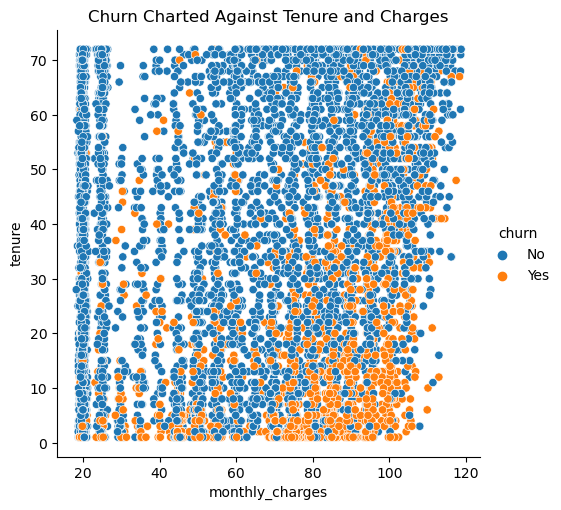

In [8]:
#generates scatter plot

sns.relplot(x = 'monthly_charges', y = 'tenure', hue = 'churn', 
            data = telco_clean_df).set(title = 'Churn Charted Against Tenure and Charges')
plt.show()

#### Clustering suggests a relationship between churn and high monthly charges early in tenure

### Chi Square Analysis for dependence between charge rank and churn
    null hypothesis: There is no dependence between churn and charge rank
    alt hypothesis: There is an observable dependence


In [9]:
#generates crosstab for observed 
observed1 = pd.crosstab(telco_clean_df.charge_rank, telco_clean_df.churn)
observed1

churn,No,Yes
charge_rank,,
a,1000,759
b,1306,451
c,1353,405
d,1504,254


In [10]:
#runs chi2 and generates DF
chi2_mct, p_mct, degf_mct, expected_mct = stats.chi2_contingency(observed1)
expected_mct_df = pd.DataFrame(expected_mct, columns = ['Expected No','Expected Yes'])
expected_mct_df

,Expected No,Expected Yes
0,1291.484215,467.515785
1,1290.015785,466.984215
2,1290.750000,467.250000
3,1290.750000,467.250000


In [11]:
#shows p-value
print(f' P-Value {p_mct} is less than {alpha}')

 P-Value 1.1278701326989385e-84 is less than 0.05


### additionally; a p-value lower than alpha supports the alternate hypothesis that there is a relatively strong dependence

## Month-to-Month (contract type) 

In [12]:
# splits data into churn and no churn
data_001 = telco_clean_df[telco_clean_df.churn== 'Yes']
data_002 = telco_clean_df[telco_clean_df.churn== 'No']

def ct_change(df):
    for x in df:
            df.replace('Month-to-month','mtm',inplace=True)
            df.replace('One year', '1y', inplace=True)
            df.replace('Two year', '2y', inplace=True)
    return df
    
data_001 = ct_change(data_001)
data_002 = ct_change(data_002)

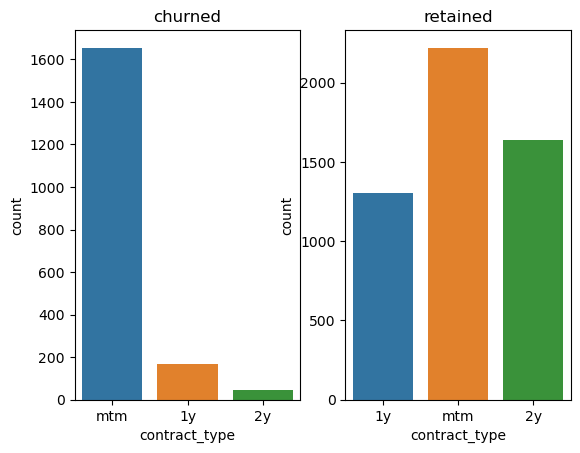

In [13]:
#charts contract type while controlling for churn

plt.subplot(1, 2, 1)
sns.countplot(x=data_001["contract_type"]).set(title = "churned")
plt.subplot(1, 2, 2)
sns.countplot(x=data_002["contract_type"]).set(title = "retained")

plt.show()



### Chi Square analysis for dependence between churn and contract type
    Null: There is no dependence between churn and contract type
    Alt: There is an observable dependence

In [14]:
#crosstab for observed contract type
observed2 = pd.crosstab(telco_clean_df.contract_type, telco_clean_df.churn)
observed2

churn,No,Yes
contract_type,,
Month-to-month,2220,1655
One year,1306,166
Two year,1637,48


In [15]:
#runs chi2 and generates DF
chi2_mtm, p_mtm, degf_mtm, expected_mtm = stats.chi2_contingency(observed2)
expected_mtm_df = pd.DataFrame(expected_mtm, columns = ['Expected No','Expected Yes'])
expected_mtm_df

,Expected No,Expected Yes
0,2845.083191,1029.916809
1,1080.764505,391.235495
2,1237.152304,447.847696


In [16]:
#prints p-value
print(f' P-Value {p_mtm} is less than {alpha}')

 P-Value 7.326182186265472e-257 is less than 0.05


### p-value lower than alpha supports the alternate hypothesis that there is a moderate dependence

## service type (fiber optics)

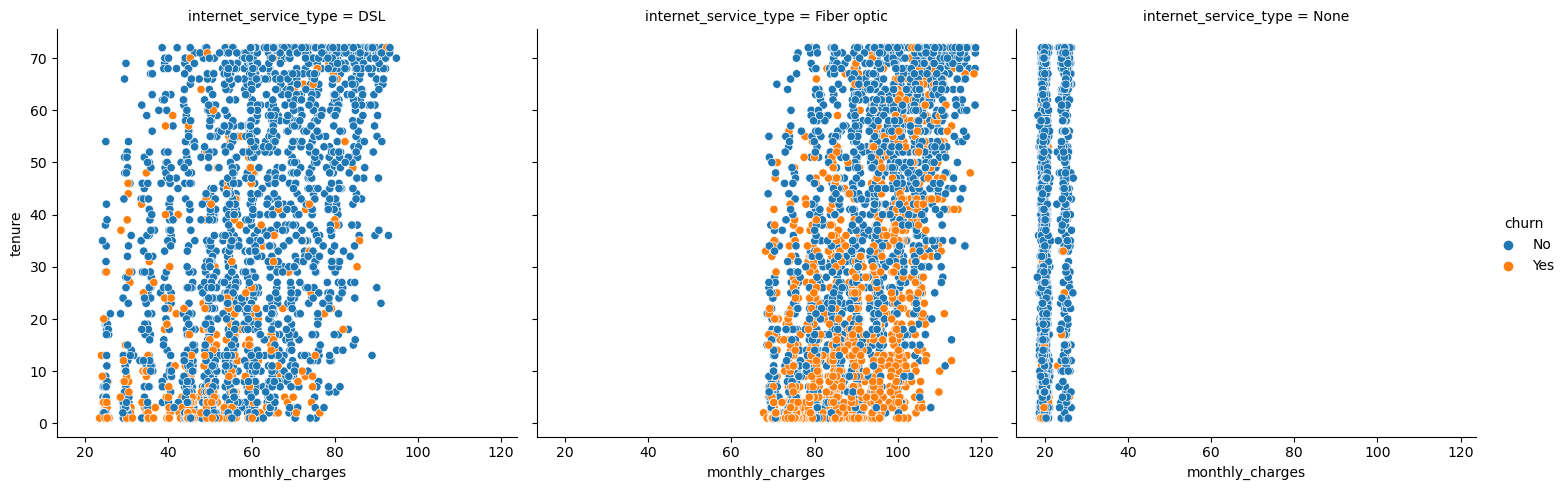

In [17]:
#generates scatterplots for service type
sns.relplot(x = 'monthly_charges', y = 'tenure', col = 'internet_service_type', hue = 'churn',
            data = telco_clean_df)
plt.show()

### Chi Square analysis for dependence between churn and service type (fiber optics)
    Null: There is no dependence between churn and service type
    Alt: There is dependence
    

In [18]:
#sets observed and generates crosstab
observed3 = pd.crosstab(telco_clean_df.internet_service_type, telco_clean_df.churn)
observed3

churn,No,Yes
internet_service_type,,
DSL,1957,459
Fiber optic,1799,1297
None,1407,113


In [19]:
#runs chi square and outputs values
chi2_ist, p_ist, degf_ist, expected_ist = stats.chi2_contingency(observed2)
expected_ist_df = pd.DataFrame(expected_mtm, columns = ['Expected No','Expected Yes'])
chi2_ist, p_ist, degf_ist, expected_ist_df

(1179.5458287339445,
 7.326182186265472e-257,
 2,
    Expected No  Expected Yes
 0  2845.083191   1029.916809
 1  1080.764505    391.235495
 2  1237.152304    447.847696)

In [20]:
#prints p-value
print(f' P-Value {p_ist} is less than {alpha}')

 P-Value 7.326182186265472e-257 is less than 0.05


### additionally; a p-value lower than alpha supports the alternate hypothesis that there is a relatively strong dependence

## Senior Citizen Status

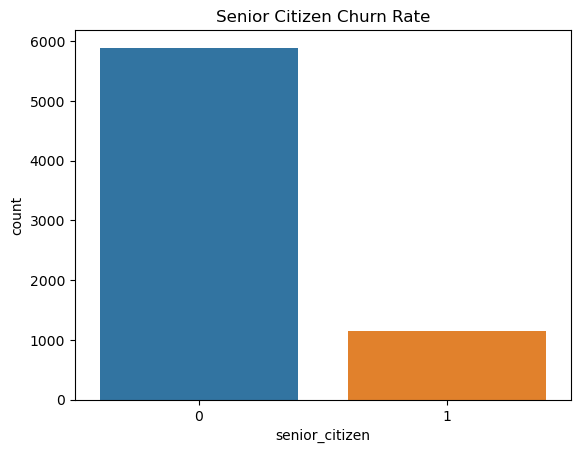

In [21]:
#generates barplot for senior citizens 
sns.countplot(x=telco_clean_df["senior_citizen"]).set(title = 'Senior Citizen Churn Rate')
plt.show()

# Takeaways
   ## Total Charges, Contract Type, Service Type
   ### All show a relatively strong impact on churn in data
   ### very small p-values for Chi square analytical test supports conclusion of dependence
   ### alternate hypothesis is supported
   
   ## Senior Citizen Status
   ### data exploration idicates some impact on churn
   ### data isn't explicit enough to support thorough statistical analysis of age as an impact


# Modeling


In [22]:
#generates baseline accuracy
bsl = 1-(y_train.sum()/len(y_train))
print(f'baseline accuracy is: {bsl}')
bsl

baseline accuracy is: 0.7342543681430314


0.7342543681430314

## Decision Tree

In [23]:
#sets decision tree variable
clf = DecisionTreeClassifier(max_depth = 5, random_state = seed)

In [24]:
#fits the tree
clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=99)

In [25]:
train_preds = clf.predict(x_train)

In [26]:
#validate predictions set to variable
val_preds = clf.predict(x_val)

In [27]:
#prints classification report
pd.DataFrame(classification_report(y_train, train_preds, output_dict = True))


,0,1,accuracy,macro avg,weighted avg
precision,0.844000,0.616894,0.789923,0.730447,0.783648
recall,0.875761,0.552752,0.789923,0.714257,0.789923
f1-score,0.859587,0.583065,0.789923,0.721326,0.786102
support,3614.000000,1308.000000,0.789923,4922.000000,4922.000000


In [28]:
#generates training set score
clf.score(x_train, y_train)

0.78992279561154

In [29]:
#generates validation set score
clf.score(x_val, y_val)

0.7687203791469195

## K Nearest Neighbor


In [30]:
# sets variable to KNN and fits to training set
knn = KNeighborsClassifier(n_neighbors = 16)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=16)

In [31]:
#generates classification report
train_preds = knn.predict(x_train)
pd.DataFrame(classification_report(y_train, train_preds, output_dict = True))

,0,1,accuracy,macro avg,weighted avg
precision,0.845600,0.683398,0.811459,0.764499,0.802495
recall,0.909242,0.541284,0.811459,0.725263,0.811459
f1-score,0.876267,0.604096,0.811459,0.740181,0.803938
support,3614.000000,1308.000000,0.811459,4922.000000,4922.000000


In [32]:
#scores knn with training set
knn.score(x_train,y_train)

0.8114587566030069

In [33]:
# scores knn with validation set
knn.score(x_val,y_val)

0.7630331753554502

## Random Forest

In [34]:
#sets variable to Random Forest
rf_telco = RandomForestClassifier(max_depth = 8, random_state = seed, min_samples_leaf = 4, max_samples = 0.5)

In [35]:
#fits the forest to the training set
for1 = rf_telco.fit(x_train, y_train)

In [36]:
#sets variable to training predictions
train_preds = rf_telco.predict(x_train)

In [37]:
#generates classification report
pd.DataFrame(classification_report(y_train, train_preds, output_dict = True))



,0,1,accuracy,macro avg,weighted avg
precision,0.836410,0.683557,0.80638,0.759984,0.79579
recall,0.915329,0.505352,0.80638,0.710340,0.80638
f1-score,0.874092,0.581099,0.80638,0.727595,0.79623
support,3614.000000,1308.000000,0.80638,4922.000000,4922.00000


In [38]:
#generates score for training set
for1.score(x_train, y_train)

0.8063795205201137

In [39]:
#generates score for validation set
for1.score(x_val,y_val)

0.7867298578199052

In [40]:
#generates score for the test set
for1.score(x_test, y_test)

0.7943127962085308

## Summary and Conclusions
   ### Without over-fitting the model that performed the best was the Random Forest Model but not be a very large model
   ### When scored against the Test set the model perfomed better than the baseline


## The results indicate a strong feature weight in contract type, service provided, and monthly charges
   ### Marketing team should look at incentivizing away from month-to-month contracts and offering special discounts on initial bills for certain services

In [133]:
#generates partdata frame of predictions and probabilites

test_preds = pd.DataFrame(rf_telco.predict(x_test))
test_preds.rename(columns = {0:'Churn Prediction'}, inplace = True)
ids = pd.DataFrame(telco_test.customer_id)
ids.rename(columns = {0:'ID'}, inplace = True)
ids.reset_index(inplace = True)
proba = pd.DataFrame(for1.predict_proba(x_test))
proba.rename(columns = {0:'Retain Probability', 1:'Churn Probability'}, inplace = True)


In [134]:
#makes the dataframe deliverable
predictions = pd.concat([ids, test_preds, proba], ignore_index = True, verify_integrity=True, axis = 1)


In [135]:
#renames columns
predictions.rename(columns = {0:'x',1:'ID',2:'Churn Prediction',3:'Retain Probability', 
                              4:'Churn Probability'}, inplace = True)



In [140]:
#drops old index
predictions.drop(['x'], axis = 1, inplace = True)
predictions

,ID,Churn Prediction,Retain Probability,Churn Probability
0,0129-QMPDR,0,0.981511,0.018489
1,8648-PFRMP,1,0.473356,0.526644
2,8769-KKTPH,0,0.846848,0.153152
3,1306-RPWXZ,0,0.987825,0.012175
4,5119-KEPFY,0,0.505748,0.494252
...,...,...,...,...
1050,1927-QEWMY,0,0.992178,0.007822
1051,4102-HLENU,0,0.989163,0.010837
1052,8884-FEEWR,0,0.970980,0.029020
1053,8782-LKFPK,0,0.647726,0.352274


In [142]:
#exports as CSV
predictions.to_csv(r'/Users/fullspectrum/codeup-data-science/classification-project001-TCC/predictions.csv', index=False, header=True)